In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys, string, random
from datetime import datetime
from omegaconf import OmegaConf
import wandb
import torch
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from monai.networks.nets import UNet

sys.path.append('../')
from data_utils import MNMv2DataModule
from unet import LightningSegmentationModel



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

In [2]:
# load configs
mnmv2_config   = OmegaConf.load('../../configs/mnmv2.yaml')
unet_config    = OmegaConf.load('../../configs/monai_unet.yaml')
trainer_config = OmegaConf.load('../../configs/unet_trainer.yaml')

In [3]:
# init datamodule
datamodule = MNMv2DataModule(
    data_dir=mnmv2_config.data_dir,
    vendor_assignment=mnmv2_config.vendor_assignment,
    batch_size=mnmv2_config.batch_size,
    binary_target=mnmv2_config.binary_target,
    non_empty_target=mnmv2_config.non_empty_target,
)

In [4]:
datamodule.setup(stage='fit')

In [5]:
# init model

cfg = OmegaConf.create({
    'unet_config': unet_config,
    'binary_target': True if unet_config.out_channels == 1 else False,
    'lr': unet_config.lr,
    'patience': unet_config.patience,
    'dataset': OmegaConf.to_container(mnmv2_config),
    'unet': OmegaConf.to_container(unet_config),
    'trainer': OmegaConf.to_container(trainer_config),
})

model = LightningSegmentationModel(cfg=cfg)


In [7]:
# # infered variable
# patience = unet_config.patience * 2

# now = datetime.now()
# filename = 'mnmv2-' + now.strftime("%H-%M_%d-%m-%Y")

# # init trainer
# if trainer_config.logging:
#     wandb.finish()
#     logger = WandbLogger(
#         project="lightning", 
#         log_model=True, 
#         name=filename
#     )
# else:
#     logger = None

# # trainer
# trainer = L.Trainer(
#     limit_train_batches=trainer_config.limit_train_batches,
#     max_epochs=trainer_config.max_epochs,
#     logger=logger,
#     callbacks=[
#         EarlyStopping(
#             monitor=trainer_config.early_stopping.monitor, 
#             mode=trainer_config.early_stopping.mode, 
#             patience=patience
#         ),
#         ModelCheckpoint(
#             dirpath=trainer_config.model_checkpoint.dirpath,
#             filename=filename,
#             save_top_k=trainer_config.model_checkpoint.save_top_k, 
#             monitor=trainer_config.model_checkpoint.monitor,
#         )
#     ],
#     precision='16-mixed',
#     gradient_clip_val=0.5,
#     devices=[0]
# )

In [8]:
# trainer.fit(model, datamodule=datamodule)

In [6]:
checkpoint_path = '../../pre-trained/trained_UNets/mnmv2-10-12_06-11-2024.ckpt'

load_as_lightning_module = True#False
load_as_pytorch_module = False#True

if load_as_lightning_module:
    unet_config    = OmegaConf.load('../../configs/monai_unet.yaml')
    unet = UNet(
        spatial_dims=unet_config.spatial_dims,
        in_channels=unet_config.in_channels,
        out_channels=unet_config.out_channels,
        channels=[unet_config.n_filters_init * 2 ** i for i in range(unet_config.depth)],
        strides=[2] * (unet_config.depth - 1),
        num_res_units=4
    )
    
    model = LightningSegmentationModel.load_from_checkpoint(
        checkpoint_path,
        map_location=torch.device("cpu"),
        model=unet,
        binary_target=True if unet_config.out_channels == 1 else False,
        lr=unet_config.lr,
        patience=unet_config.patience,
        # cfg=OmegaConf.to_container(unet_config)
    )

elif load_as_pytorch_module:
    checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
    model_state_dict = checkpoint['state_dict']
    model_state_dict = {k.replace('model.model.', 'model.'): v for k, v in model_state_dict.items() if k.startswith('model.')}
    model_config = checkpoint['hyper_parameters']['cfgs']

    print(model_config)

    unet = UNet(
        spatial_dims=model_config['unet']['spatial_dims'],
        in_channels=model_config['unet']['in_channels'],
        out_channels=model_config['unet']['out_channels'],
        channels=[model_config['unet']['n_filters_init'] * 2 ** i for i in range(model_config['unet']['depth'])],
        strides=[2] * (model_config['unet']['depth'] - 1),
        num_res_units=4
    )

    unet.load_state_dict(model_state_dict)

/home/mikhelson/MedImSeg-Lab24/CLUE/lib/python3.8/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [ ]:
model.cfg

{'unet_config': {'n_filters_init': 16, 'depth': 4, 'spatial_dims': 2, 'in_channels': 1, 'out_channels': 4, 'num_res_units': 4, 'lr': 0.001, 'patience': 5, 'clue_softmax_t': 1.0}, 'binary_target': False, 'lr': 0.001, 'patience': 5, 'dataset': {'data_dir': '/home/mikhelson/MedImSeg-Lab24/data/MNM/', 'vendor_assignment': {'train': 'siemens', 'test': 'ge'}, 'batch_size': 32, 'binary_target': False, 'non_empty_target': False}, 'unet': {'n_filters_init': 16, 'depth': 4, 'spatial_dims': 2, 'in_channels': 1, 'out_channels': 4, 'num_res_units': 4, 'lr': 0.001, 'patience': 5, 'clue_softmax_t': 1.0}, 'trainer': {'train_transforms': 'global_transforms', 'limit_train_batches': 50, 'max_epochs': 100, 'early_stopping': {'monitor': 'val_loss', 'mode': 'min'}, 'model_checkpoint': {'save_top_k': 2, 'dirpath': '../../pre-trained/trained_UNets', 'monitor': 'val_loss'}, 'logging': True}}

: 

### CLUE

In [1]:
# Объединяем все временные файлы в один
import glob
import numpy as np
from tqdm import tqdm
import os
import pickle
import sys

sys.path.append('../')
temp_dir = "temp_files"
# os.makedirs(temp_dir, exist_ok=True)
# print(os.makedirs(temp_dir, exist_ok=True))
embeddings = []
pixel_scores = []

print("Merging temporary files...")
embeddings_files = sorted(glob.glob(f"{temp_dir}/embeddings_*.npy"))
print(embeddings_files)
scores_files = sorted(glob.glob(f"{temp_dir}/scores_*.npy"))

for emb_file, score_file in tqdm(zip(embeddings_files, scores_files), total=len(embeddings_files)):
    embeddings.append(np.load(emb_file))
    pixel_scores.append(np.load(score_file))
    break

embeddings = np.concatenate(embeddings, axis=0)
pixel_scoress = np.concatenate(pixel_scores, axis=0)

# Сохраняем объединённые данные в кеш
# with open('embeddings_weights.pkl', "wb") as f:
#     pickle.dump((embeddings, pixel_scores), f)
# print(f"Saved embeddings and scores to cache")

Merging temporary files...
['temp_files/embeddings_0.npy', 'temp_files/embeddings_1.npy', 'temp_files/embeddings_10.npy', 'temp_files/embeddings_100.npy', 'temp_files/embeddings_101.npy', 'temp_files/embeddings_102.npy', 'temp_files/embeddings_103.npy', 'temp_files/embeddings_104.npy', 'temp_files/embeddings_11.npy', 'temp_files/embeddings_12.npy', 'temp_files/embeddings_13.npy', 'temp_files/embeddings_14.npy', 'temp_files/embeddings_15.npy', 'temp_files/embeddings_16.npy', 'temp_files/embeddings_17.npy', 'temp_files/embeddings_18.npy', 'temp_files/embeddings_19.npy', 'temp_files/embeddings_2.npy', 'temp_files/embeddings_20.npy', 'temp_files/embeddings_21.npy', 'temp_files/embeddings_22.npy', 'temp_files/embeddings_23.npy', 'temp_files/embeddings_24.npy', 'temp_files/embeddings_25.npy', 'temp_files/embeddings_26.npy', 'temp_files/embeddings_27.npy', 'temp_files/embeddings_28.npy', 'temp_files/embeddings_29.npy', 'temp_files/embeddings_3.npy', 'temp_files/embeddings_30.npy', 'temp_files

  0%|          | 0/105 [00:31<?, ?it/s]


In [ ]:
import os
import torch
import pickle
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

class CLUESamplingSegmentation:
    """
    Implements CLUE for Segmentation: Clustering via Uncertainty-weighted Embeddings at pixel-level.
    """
    def __init__(self, dset, model, device, args, cache_path):
        self.dset = dset
        self.model = model
        self.device = device
        self.args = args
        self.T = args.clue_softmax_t
        self.cache_path = cache_path

    def get_pixel_embeddings(self, model, loader, device, emb_dim=512):
        # Проверяем, существует ли кеш-файл
        if os.path.exists(self.cache_path):
            print(f"Loading embeddings and scores from cache: {self.cache_path}")
            with open(self.cache_path, "rb") as f:
                embeddings, pixel_scores = pickle.load(f)
            return embeddings, pixel_scores

        print("Extracting pixel embeddings and uncertainty scores (this may take some time)...")
        model.eval()
        embeddings = []
        pixel_scores = []
        
        with torch.no_grad():
            for i, batch in enumerate(tqdm(loader, desc="Extracting Pixel Embeddings")):
                data = batch["data"].to(device)

                # Извлекаем эмбеддинги предпоследнего слоя
                pred, emb_pen = model(data, with_emb=True)
                emb_pen = emb_pen.permute(0, 2, 3, 1).reshape(-1, emb_pen.shape[1])

                # Получаем логиты и вычисляем неопределённость
                pred = pred.cpu()
                probs = nn.Softmax(dim=1)(pred / self.T)
                probs += 1e-8
                uncertainty = -(probs * torch.log(probs)).sum(dim=1).cpu().numpy().flatten()

                embeddings.append(emb_pen.cpu().numpy())
                pixel_scores.append(uncertainty)

        # Объединяем все эмбеддинги и неопределённости
        embeddings = np.concatenate(embeddings, axis=0)
        pixel_scores = np.concatenate(pixel_scores, axis=0)

        # Сохраняем эмбеддинги и неопределённости в кеш-файл. Потому что занимает около 15 минут
        with open(self.cache_path, "wb") as f:
            pickle.dump((embeddings, pixel_scores), f)
        print(f"Saved embeddings and scores to cache: {self.cache_path}")

        return embeddings, pixel_scores

    def query(self, n_samples, loader):
        # Извлекаем эмбеддинги и неопределённость пикселей
        pixel_embeddings, pixel_scores = embeddings, pixel_scoress #self.get_pixel_embeddings(self.model, loader, self.device)

        # Применяем K-Means, взвешивая по неопределённости
        kmeans = KMeans(n_clusters=n_samples)
        kmeans.fit(pixel_embeddings, sample_weight=pixel_scores)

        dists = euclidean_distances(kmeans.cluster_centers_, pixel_embeddings)
        sort_idxs = dists.argsort(axis=1)
        selected_indices = []
        ax, rem = 0, n_samples
        while rem > 0:
            selected_indices.extend(list(sort_idxs[:, ax][:rem]))
            selected_indices = list(set(selected_indices))  # Убираем повторения
            rem = n_samples - len(selected_indices)
            ax += 1
        return selected_indices

# Пример использования
# datamodule.setup(stage='fit')
train_loader = datamodule.train_dataloader()
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
clue_sampler = CLUESamplingSegmentation(dset=datamodule.mnm_train, model=model, device=device, args=unet_config, cache_path='../../checkpoints/emb_and_weights.pkl')
selected_pixel_indices = clue_sampler.query(n_samples=3, loader=train_loader)

print("Selected pixel indices:", selected_pixel_indices)


/home/mikhelson/MedImSeg-Lab24/CLUE/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: sample_weight.shape == (1048576000,), expected (262144000,)!

: 

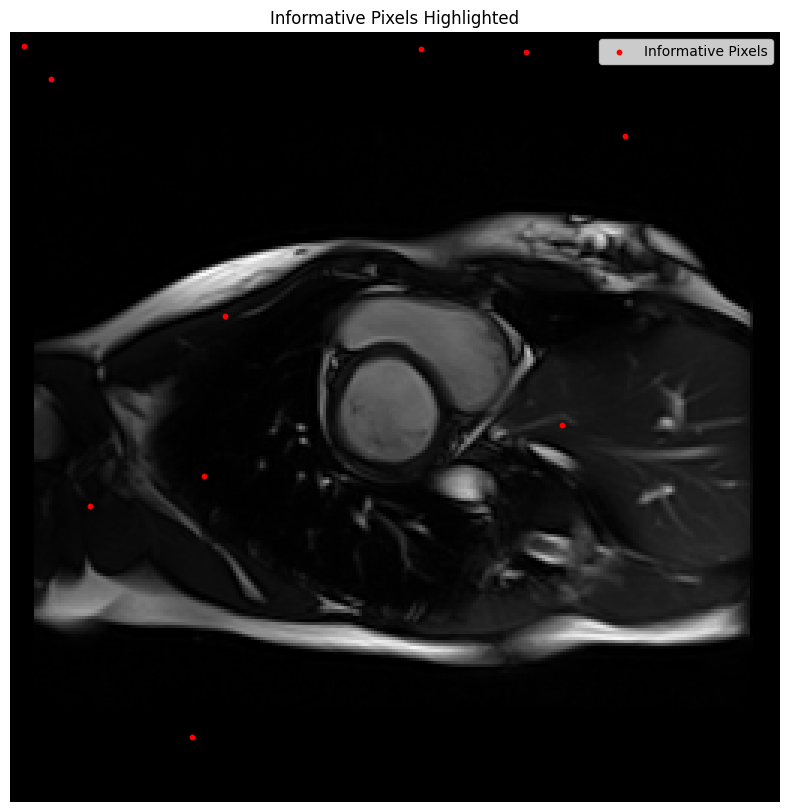

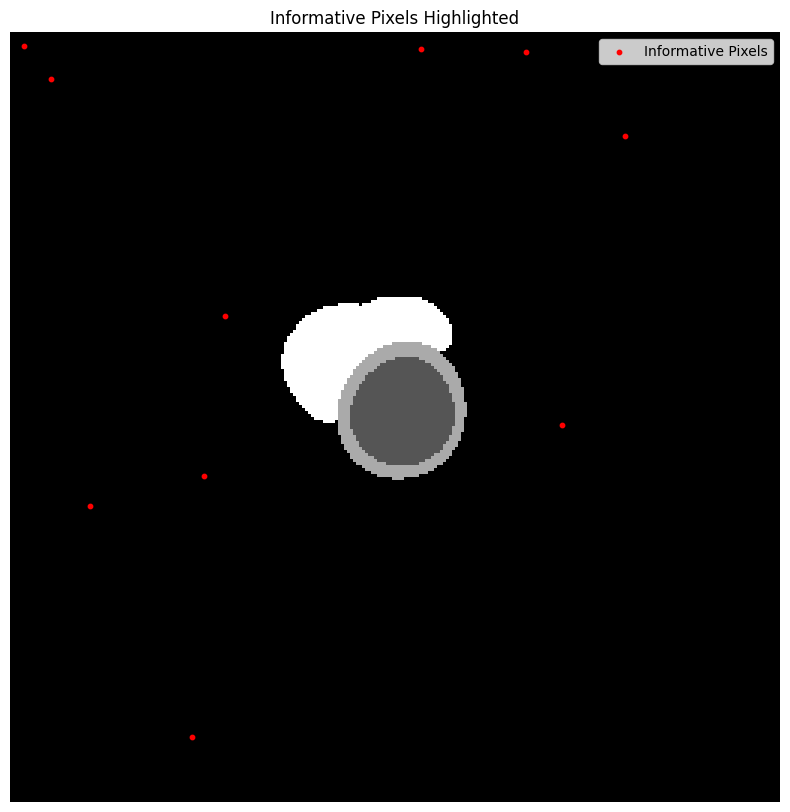

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Функция для отрисовки изображения с выделенными информативными пикселями
def plot_informative_pixels(image, selected_pixel_indices, height, width):
    # Преобразуем изображение из формата тензора в numpy
    image_np = image.cpu().numpy().transpose(1, 2, 0) if len(image.shape) == 3 else image.squeeze().cpu().numpy()

    # Создаём пустую маску для выделения пикселей
    mask = np.zeros((height, width), dtype=bool)

    # Отмечаем выбранные пиксели на маске
    for idx in selected_pixel_indices:
        h = (idx % (height * width)) // width
        w = (idx % (height * width)) % width
        mask[h, w] = True

    # Отрисовываем изображение
    plt.figure(figsize=(10, 10))
    plt.imshow(image_np, cmap='gray')
    plt.scatter(np.where(mask)[1], np.where(mask)[0], color='red', s=10, label='Informative Pixels')
    plt.title('Informative Pixels Highlighted')
    plt.axis('off')
    plt.legend()
    plt.show()

train_loader = datamodule.train_dataloader()
# Выбираем одно изображение из DataLoader
for batch in train_loader:
    image = batch["data"][0]  # Берём первое изображение в батче
    break

# Параметры изображения
height, width = image.shape[-2], image.shape[-1]

# Отрисовываем изображение с выделенными информативными пикселями
plot_informative_pixels(image, list([4166464, 9700356, 548423, 2164104, 5572267, 3416780, 20975373, 24674999, 20159770, 16247356]), height, width)

for batch in train_loader:
    image = batch["target"][0]  # Берём первое изображение в батче
    break

# Параметры изображения
height, width = image.shape[-2], image.shape[-1]

# Отрисовываем изображение с выделенными информативными пикселями
plot_informative_pixels(image, list([4166464, 9700356, 548423, 2164104, 5572267, 3416780, 20975373, 24674999, 20159770, 16247356]), height, width)


In [10]:
l = np.arange(1, 20)
l[:-1]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

In [15]:
import os
import glob
import pickle
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

import sys, string, random
from datetime import datetime
from omegaconf import OmegaConf
import wandb
import torch
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data.sampler import Sampler, SubsetRandomSampler
from monai.networks.nets import UNet

sys.path.append('../')
from data_utils import MNMv2DataModule
from unet import LightningSegmentationModel
import torch.nn.functional as F

class ActualSequentialSampler(Sampler):
	r"""Samples elements sequentially, always in the same order.

	Arguments:
		data_source (Dataset): dataset to sample from
	"""

	def __init__(self, data_source):
		self.data_source = data_source

	def __iter__(self):
		return iter(self.data_source)

	def __len__(self):
		return len(self.data_source)
     
class CLUESampling:
    """
    Implements CLUE: Clustering via Uncertainty-weighted Embeddings for segmentation tasks.
    """
    def __init__(self, dset, model, device, args, balanced=False):
        self.dset = dset
        self.model = model
        self.device = device
        self.args = args
        self.random_state = np.random.RandomState(1234)
        self.T = args.clue_softmax_t
    
    def get_embedding(self, model, loader, device, args, with_emb=False):
        model.eval()
        embedding_pen = None
        embedding = None
        emb_dim = None
        batch_sz = args.batch_size
        num_samples = len(self.dset)

        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(loader)):
                data = batch['data'].to(device)

                if with_emb:
                    e1, e2 = model(data, with_emb=True)
                else:
                    e1 = model(data, with_emb=False)

                # Приводим размер логитов к размеру эмбеддингов
                height2, width2 = e2.shape[2], e2.shape[3]
                e1 = F.interpolate(e1, size=(height2, width2), mode='bilinear', align_corners=False)

                if embedding_pen is None:
                    emb_dim = e2.shape[1]
                    num_classes = e1.shape[1]
                    embedding_pen = torch.zeros((num_samples * height2 * width2, emb_dim), device='cpu')
                    embedding = torch.zeros((num_samples * height2 * width2, num_classes), device='cpu')

                # Преобразуем логиты и эмбеддинги для каждого пикселя
                e1 = e1.permute(0, 2, 3, 1).reshape(-1, num_classes)
                e2 = e2.permute(0, 2, 3, 1).reshape(-1, emb_dim)

                # Вычисляем текущие индексы
                start_idx = batch_idx * batch_sz * height2 * width2
                end_idx = start_idx + min(batch_sz * height2 * width2, e2.shape[0])

                # Заполняем тензоры
                embedding[start_idx:end_idx, :] = e1.cpu()
                embedding_pen[start_idx:end_idx, :] = e2.cpu()

                if batch_idx > 50:
                    break
        return embedding, embedding_pen
    
    def query(self, n, data_loader):
        self.model.eval()

        # Получаем эмбеддинги для пикселей
        tgt_emb, tgt_pen_emb = self.get_embedding(self.model, data_loader, self.device, self.args, with_emb=True)

        # Используем предпоследние эмбеддинги (tgt_pen_emb)
        tgt_pen_emb = tgt_pen_emb.cpu().numpy()

        # Вычисляем неопределенность через энтропию для каждого пикселя
        tgt_scores = nn.Softmax(dim=1)(tgt_emb / self.T)
        tgt_scores += 1e-8
        sample_weights = -(tgt_scores * torch.log(tgt_scores)).sum(1).cpu().numpy()

        # Запуск K-means с учетом весов неопределенности
        km = KMeans(n)
        km.fit(tgt_pen_emb, sample_weight=sample_weights)

        # Находим ближайшие пиксели к центроидам кластеров
        dists = euclidean_distances(km.cluster_centers_, tgt_pen_emb)
        sort_idxs = dists.argsort(axis=1)
        q_idxs = []
        ax, rem = 0, n
        while rem > 0:
            q_idxs.extend(list(sort_idxs[:, ax][:rem]))
            q_idxs = list(set(q_idxs))
            rem = n - len(q_idxs)
            ax += 1

        return q_idxs, tgt_pen_emb, sample_weights, km

if __name__ == '__main__':
    mnmv2_config   = OmegaConf.load('../../configs/mnmv2.yaml')
    unet_config    = OmegaConf.load('../../configs/monai_unet.yaml')
    trainer_config = OmegaConf.load('../../configs/unet_trainer.yaml')

    # init datamodule
    datamodule = MNMv2DataModule(
        data_dir=mnmv2_config.data_dir,
        vendor_assignment=mnmv2_config.vendor_assignment,
        batch_size=mnmv2_config.batch_size,
        binary_target=mnmv2_config.binary_target,
        non_empty_target=mnmv2_config.non_empty_target,
    )

    datamodule.setup(stage='fit')

    # init model
    cfg = OmegaConf.create({
        'unet_config': unet_config,
        'binary_target': True if unet_config.out_channels == 1 else False,
        'lr': unet_config.lr,
        'patience': unet_config.patience,
        'dataset': OmegaConf.to_container(mnmv2_config),
        'unet': OmegaConf.to_container(unet_config),
        'trainer': OmegaConf.to_container(trainer_config),
    })

    model = LightningSegmentationModel(cfg=cfg)

    # TODO: Add argument for training 

    # # infered variable
    # patience = unet_config.patience * 2

    # now = datetime.now()
    # filename = 'mnmv2-' + now.strftime("%H-%M_%d-%m-%Y")

    # # init trainer
    # if trainer_config.logging:
    #     wandb.finish()
    #     logger = WandbLogger(
    #         project="lightning", 
    #         log_model=True, 
    #         name=filename
    #     )
    # else:
    #     logger = None

    # # trainer
    # trainer = L.Trainer(
    #     limit_train_batches=trainer_config.limit_train_batches,
    #     max_epochs=trainer_config.max_epochs,
    #     logger=logger,
    #     callbacks=[
    #         EarlyStopping(
    #             monitor=trainer_config.early_stopping.monitor, 
    #             mode=trainer_config.early_stopping.mode, 
    #             patience=patience
    #         ),
    #         ModelCheckpoint(
    #             dirpath=trainer_config.model_checkpoint.dirpath,
    #             filename=filename,
    #             save_top_k=trainer_config.model_checkpoint.save_top_k, 
    #             monitor=trainer_config.model_checkpoint.monitor,
    #         )
    #     ],
    #     precision='16-mixed',
    #     gradient_clip_val=0.5,
    #     devices=[0]
    # )

    # trainer.fit(model, datamodule=datamodule)

    checkpoint_path = '../../pre-trained/trained_UNets/mnmv2-10-12_06-11-2024.ckpt'

    load_as_lightning_module = True#False
    load_as_pytorch_module = False#True

    if load_as_lightning_module:
        unet_config    = OmegaConf.load('../../configs/monai_unet.yaml')
        unet = UNet(
            spatial_dims=unet_config.spatial_dims,
            in_channels=unet_config.in_channels,
            out_channels=unet_config.out_channels,
            channels=[unet_config.n_filters_init * 2 ** i for i in range(unet_config.depth)],
            strides=[2] * (unet_config.depth - 1),
            num_res_units=4
        )
        
        model = LightningSegmentationModel.load_from_checkpoint(
            checkpoint_path,
            map_location=torch.device("cpu"),
            model=unet,
            binary_target=True if unet_config.out_channels == 1 else False,
            lr=unet_config.lr,
            patience=unet_config.patience,
            # cfg=OmegaConf.to_container(unet_config)
        )

    elif load_as_pytorch_module:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
        model_state_dict = checkpoint['state_dict']
        model_state_dict = {k.replace('model.model.', 'model.'): v for k, v in model_state_dict.items() if k.startswith('model.')}
        model_config = checkpoint['hyper_parameters']['cfgs']

        print(model_config)

        unet = UNet(
            spatial_dims=model_config['unet']['spatial_dims'],
            in_channels=model_config['unet']['in_channels'],
            out_channels=model_config['unet']['out_channels'],
            channels=[model_config['unet']['n_filters_init'] * 2 ** i for i in range(model_config['unet']['depth'])],
            strides=[2] * (model_config['unet']['depth'] - 1),
            num_res_units=4
        )

        unet.load_state_dict(model_state_dict)
    
    train_loader = datamodule.train_dataloader()
    device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    clue_sampler = CLUESampling(dset=datamodule.mnm_train, 
                                model=model, 
                                device=device, 
                                args=unet_config, )
                                            #cache_path='../../MedImSeg-Lab24/checkpoints/emb_and_weights.pkl')
    
    q_idxs, tgt_pen_emb, sample_weights, km = clue_sampler.query(n=2, data_loader=train_loader)

    # # Сохраняем выбранные индексы в кеш
    # with open('../../MedImSeg-Lab24/checkpoints/selected_indices.pkl', "wb") as f:
    #     pickle.dump(selected_pixel_indices, f)
    # print(f"Saved selected indices to cache: {'../../MedImSeg-Lab24/checkpoints/selected_indices.pkl'}")
    
    # print("Selected pixel indices:", selected_pixel_indices)

/home/mikhelson/MedImSeg-Lab24/CLUE/lib/python3.8/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
51it [00:05,  9.54it/s]
/home/mikhels

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_clusters(image, tgt_pen_emb, sample_weights, km, height, width):
    # Получаем метки кластеров для каждого пикселя изображения
    cluster_labels = km.labels_

    # Восстанавливаем карту кластеров для изображения
    cluster_map = cluster_labels.reshape(height, width)

    # Визуализируем результат
    plt.figure(figsize=(18, 6))

    # Исходное изображение
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # Карта кластеров
    plt.subplot(1, 3, 2)
    plt.imshow(cluster_map, cmap='tab20')
    plt.title("Cluster Map (KMeans Segmentation)")
    plt.axis("off")

    # Карта неопределенностей
    uncertainty_map = sample_weights.reshape(height, width)
    plt.subplot(1, 3, 3)
    plt.imshow(uncertainty_map, cmap='viridis')
    plt.colorbar()
    plt.title("Uncertainty Map")
    plt.axis("off")

    plt.show()


for batch in train_loader:
    image = batch["data"][0]  # Берём первое изображение в батче
    break
# Предположим, что ваше изображение имеет размеры height и width
height, width = image.shape[1], image.shape[2]

# Визуализируем результат
visualize_clusters(image=image.permute(1, 2, 0).cpu().numpy(),
                   tgt_pen_emb=tgt_pen_emb,
                   sample_weights=sample_weights,
                   km=km,
                #    q_idxs=q_idxs,
                   height=height,
                   width=width)

ValueError: cannot reshape array of size 74563584 into shape (256,256)